<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/geexgb/xgboost/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_source_control_pane()
# ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 5.50 KiB | 5.50 MiB/s, done.
Resolving deltas: 100% (4/4), done.


interactive(children=(Text(value='', description='Email', placeholder='Enter email'), Text(value='', descripti…

In [3]:
#@title Options.
import raster
import dataset
import importlib
import gaussian

importlib.reload(raster)
importlib.reload(dataset)
importlib.reload(gaussian)
_OVERLAP_PARTITION_STRATEGY = dataset.FixedPartitionStrategy(
  # Train
  dataset.DatasetGeographicPartitions(
    min_longitude=-62.5,
    max_longitude=float('inf'),
    min_latitude=-5,
    max_latitude=float('inf'),
  ),
  # Validation
  dataset.DatasetGeographicPartitions(
    min_longitude=float('-inf'),
    max_longitude=float('inf'),
    min_latitude=float('-inf'),
    max_latitude=-5
  ),
  # Test
  dataset.DatasetGeographicPartitions(
    min_longitude=float('-inf'),
    max_longitude=float('inf'),
    min_latitude=float('-inf'),
    max_latitude=float('inf')
  )
)

# @markdown *The data sets used to train and validate with*
_TRAINING_SET_TIMBERID = '<TimberID>'
_TRAINING_SET_EMULATED = '<Emulated>'
TRAINING_SET = 'uc_davis_2023_08_26_isoscapes_train_random_grouped.csv' # @param ["2023_06_23_Results_Google.csv", "uc_davis_2023_08_26_isoscapes_train_fixed_grouped.csv","uc_davis_2023_08_26_isoscapes_train_random_grouped.csv","<Emulated>", "<TimberID>"] {allow-input: true}
_VALIDATION_SET_PARTITION_FIXED = 'PartitionStrategy.FIXED'
_VALIDATION_SET_PARTITION_OVERLAP = 'PartitionStrategy.OVERLAP'
VALIDATION_SET = "uc_davis_2023_08_26_isoscapes_validation_random_grouped.csv" # @param ["uc_davis_2023_08_26_isoscapes_validation_fixed_grouped.csv", "uc_davis_2023_08_26_isoscapes_validation_random_grouped.csv", "PartitionStrategy.FIXED", "PartitionStrategy.OVERLAP"] {allow-input: true}
LABEL_COLUMN = "d18O_cel_mean" # @param ["d18O_cel", "d18O_cel_mean", "cellulose_oxygen_ratio", "d18o_cel"] {allow-input: true}
GROUP_BY = "" # @param ["", "Code,lat,long", "lat,long"] {allow-input: true}
ISOSCAPE_SUFFIX = "rnd_grouped" # @param ["rnd_grouped", "fixed_grouped", "all"] {allow-input: true}

# @markdown *Path Options for training sets and rasters outside of EE*
# Raster directory. Contains:
# iso_O_cellulose.tif: Isoscape of 18O from Precipitation; <-- MODELING TARGET
# Iso_Oxi_Stack.tif: Isoscape of 18O from Precipitation; <-- Model input
# R.rh_Stack.tif: Atmospheric Relative humidity <-- Model input
# R.vpd_Stack.tif: Vapor Pressure Deficit - VPD <-- Model input
# Temperature_Stack.tif: Atmospheric Temperature <-- Model input
raster.GDRIVE_BASE = "/content/gdrive" #@param
raster.RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
raster.SAMPLE_DATA_BASE = "/MyDrive/amazon_rainforest_files/amazon_sample_data/" #@param
raster.TEST_DATA_BASE = "/MyDrive/amazon_rainforest_files/amazon_test_data/" #@param
raster.ANIMATIONS_BASE = "/MyDrive/amazon_rainforest_files/amazon_animations/" #@param
raster.MODEL_BASE = "/MyDrive/amazon_rainforest_files/amazon_isoscape_models/" #@param

# @markdown *What to rebuild*
REBUILD_MODEL = True #@param {type:"boolean"}
# If false, requires XGB oxygen isoscape in MODEL_BASE/predicted_isoscape_xgboost.tiff
REGENERATE_OXYGEN_XGB_ISOSCAPE = True #@param {type:"boolean"}
# If false, requires MODEL_BASE/xgb_means_oxygen_isoscape.tiff and MODEL_BASE/xgb_variances_oxygen_isoscape.tiff
REGENERATE_OXYGEN_XGB_MEANS_VARIANCES = True #@param {type:"boolean"}

# @markdown *Debug Options*
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
# How often should XGB log training metadata? 0 is the default, which indicates never.
XGB_VERBOSITY_LEVEL = 0 #@param

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

In [4]:
#@title Train Model.
import raster
import dataset

def clean(df: pd.DataFrame) -> pd.DataFrame:
  df = df[df[LABEL_COLUMN].notna()]
  df[LABEL_COLUMN] = df[LABEL_COLUMN].astype('float64')
  df = df[df[LABEL_COLUMN] > 0]
  cols = ['lat', 'long', LABEL_COLUMN] + [c for c in GROUP_BY.split(",") if c not in ['lat', 'long', LABEL_COLUMN]]

  print(df.columns)
  if GROUP_BY:
    grouped = df.groupby(GROUP_BY.split(","))
    df = grouped.mean().reset_index()
  df = df[['lat', 'long', LABEL_COLUMN]]

  return df

def load_training_validation() -> dataset.PartitionedDataset:
  # If emulation, we use the old method of generating datapoints from an isoscape
  if TRAINING_SET == _TRAINING_SET_EMULATED:
    assert(VALIDATION_SET == _VALIDATION_SET_PARTITION_FIXED)
    return dataset.partitioned_reference_data(None)

  # If TimberID is the source, we load from earth engine and enforce a partition
  # strategy
  if TRAINING_SET == _TRAINING_SET_TIMBERID:
    assert(VALIDATION_SET == _VALIDATION_SET_PARTITION_FIXED)
    training_data = dataset.load_reference_samples()
  else:
    #Otherwise we read the training set from the path given
    training_data = pd.read_csv(raster.get_sample_db_path(TRAINING_SET),
      encoding="ISO-8859-1", sep=',')

  # Enrich the training data using rasters
  training_data = dataset.add_features_from_rasters(clean(training_data),
                                          [raster.relative_humidity_geotiff(),
                                          raster.temperature_geotiff(),
                                          raster.vapor_pressure_deficit_geotiff(),
                                          raster.atmosphere_isoscape_geotiff()])
  training_data.reset_index().drop('index', inplace=True, axis=1)

  # Once we have training, if partition is specified, apply and return
  if VALIDATION_SET == _VALIDATION_SET_PARTITION_FIXED:
    return dataset.partition(training_data, dataset.PartitionStrategy.FIXED)

  # Final option is they specified the training and validation manually
  validation_data =pd.read_csv(
                                raster.get_sample_db_path(VALIDATION_SET),
                                encoding="ISO-8859-1", sep=',')
  validation_data = dataset.add_features_from_rasters(clean(validation_data),
                                        [raster.relative_humidity_geotiff(),
                                        raster.temperature_geotiff(),
                                        raster.vapor_pressure_deficit_geotiff(),
                                        raster.atmosphere_isoscape_geotiff()])
  validation_data.reset_index().drop('index', inplace=True, axis=1)
  return dataset.PartitionedDataset(train=training_data, test=pd.DataFrame(),
                            validation=validation_data)

def train_xgb(data: dataset.PartitionedDataset, booster: str, rounds: int) -> xgb.XGBRegressor:
  '''Trains a model using XGBoost on the PartitionedDataSet given and using the number of rounds
  specified'''
  xgb_model = xgb.XGBRegressor(n_estimators=rounds, eta=0.1, max_depth=2, objective='reg:squarederror', booster=booster)
  #reorder so that label is at -1
  cols_at_end = [LABEL_COLUMN]
  data.train = data.train[[c for c in data.train if c not in cols_at_end]
          + [c for c in cols_at_end if c in data.train]]
  data.validation = data.validation[[c for c in data.validation if c not in cols_at_end]
          + [c for c in cols_at_end if c in data.validation]]

  # split data into input and output columns
  X, y = data.train.iloc[:, :-1], data.train.iloc[:, -1]
  X_val, y_val = data.validation.iloc[:, :-1], data.validation.iloc[:, -1]
  print(data.train.columns)
  print(f"Predicting: {data.train.columns[-1]}")
  assert data.train.columns[-1] == LABEL_COLUMN #"cellulose_oxygen_ratio"
  assert data.validation.columns[-1] == LABEL_COLUMN #"cellulose_oxygen_ratio"
  xgb_model.fit(X, y, eval_set=[(X_val, y_val)], verbose=XGB_VERBOSITY_LEVEL)
  return xgb_model

def save_xgb(basename: str, model: xgb.XGBRegressor):
  '''Saves the given model to a json file so it may be loaded later with running
    training again.'''
  with open(f"{basename}_config_xgb.json", "w") as f:
    f.write(model.get_booster().save_config())
  model.save_model(f"{basename}_xgb.json")

def load_xgb(basename: str) -> xgb.XGBRegressor:
  '''Loads a previously saved xgb model.'''
  model = xgb.XGBRegressor()
  model.load_model(f"{basename}_xgb.json")
  with open(f"{basename}_config_xgb.json", "r") as f:
    model.get_booster().load_config(f.read())
  return model

def train_or_load_xgboost(basename: str, data: dataset.PartitionedDataset, rounds: int=100000):
  '''Either trains and saves a new XGBoost model or loads an existing model
    depending on the initial form parameters of this colab.'''
  if REBUILD_MODEL:
    print("Training model")
    model = train_xgb(data, booster='gblinear', rounds=rounds)
    print(model.evals_result())
    print("Saving model ", basename)
    save_xgb(basename, model)
  else:
    print("Loading model ", basename)
    model = load_xgb(basename)

  print(f"RMSE (validation): {model.evals_result()['validation_0']['rmse'][-1]}")
  return model

# Validation RMSE xgboost: 0.306059 w/ 100,000 rounds
# Validation RMSE google internal tooling: 0.39386
xgb_model = train_or_load_xgboost(
  raster.get_model_path("oxygen_isoscape_model"),
  load_training_validation(),
  rounds=100000)


Index(['Unnamed: 0', 'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
       'Mean Annual Temperature', 'Mean Annual Precipitation',
       'Iso_Oxi_Stack_mean_TERZER', 'predkrig_br_lat_ISORG',
       'isoscape_fullmodel_d18O_prec_REGRESSION', 'Code', 'Family', 'Origin',
       'd18O_cel_mean', 'd18O_cel_variance'],
      dtype='object')
Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.04166666666665718, -0.04166666666667143)
Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",

In [ ]:
#@title Test train_or_load_xgboost

# Test data created as follows:
# # Create data for unit tests
# from io import StringIO

# train_text = StringIO()
# partitioned_reference_data.validation.iloc[:10].to_csv(train_text, index=False)
# print(train_text.getvalue())

import os
import dataset

def create_test_data():
  train_txt = """lat,lon,rh,temp,vpd,atmosphere_oxygen_ratio,cellulose_oxygen_ratio
  -4.880332787307218,-69.95800610699372,0.8044400215148926,26.225001017252605,0.6966667175292969,-4.451689084370931,37.122222900390625
  -4.688096349322666,-70.44263021829333,0.80293075243632,26.35833485921224,0.7074999809265137,-4.41741943359375,37.17825063069662
  -4.872397683046066,-69.63990597562567,0.8054693539937338,26.308329264322918,0.6958333651224772,-4.417543411254883,37.1220448811849
  -4.8247274690858735,-69.81806665464333,0.8040264447530111,26.308331807454426,0.7016665935516357,-4.424846013387044,37.14974721272787
  -4.765274838163909,-70.01923594475969,0.8022874991099039,26.337496439615887,0.709166685740153,-4.418321291605632,37.20004526774088
  -4.771462642125715,-70.34365888186157,0.8011360963185629,26.508333841959637,0.7199999491373698,-4.385458946228027,37.247047424316406
  -4.798305195940103,-70.28306090761369,0.802595059076945,26.366666158040363,0.709166685740153,-4.411936124165853,37.20568339029948
  -5.223217462581197,-69.53591146126529,0.8077573776245117,26.10833231608073,0.6808333396911621,-4.4716800053914385,37.02557881673177
  -4.613341938104102,-69.7943386465883,0.8022151788075765,26.400001525878906,0.7116666634877523,-4.423205057779948,37.17969512939453
  -4.527212807226629,-69.8817482523093,0.8018482526143392,26.4499994913737,0.7149999936421713,-4.395961443583171,37.22857411702474"""
  train_df = pd.read_csv(StringIO(train_txt))

  val_txt = """lat,lon,rh,temp,vpd,atmosphere_oxygen_ratio,cellulose_oxygen_ratio
  -3.6696957825007046,-54.87948135669049,0.8142155011494955,25.770833333333332,0.6483333110809326,-3.3461217880249023,38.01644388834635
  -3.8993546066489224,-54.86859101648585,0.805713415145874,26.149998982747395,0.6933333079020182,-3.261778195699056,38.26288604736328
  -3.159593531700783,-54.93297940204632,0.819889227549235,25.912501017252605,0.6333333253860474,-3.287173271179199,37.95276896158854
  -3.9960354096696906,-54.87203413927777,0.8026766777038574,26.149998982747395,0.7041666507720947,-3.2518555323282876,38.3813222249349
  -3.80255400058822,-54.751942535999156,0.8073338667551676,26.054166158040363,0.6833333174387614,-3.302551587422689,38.1731923421224
  -12.828852720078402,-52.607319143523036,0.7082154750823975,25.258333841959637,1.0200000603993733,-3.547501564025879,39.927050272623696
  -12.532258968752565,-52.097391445126696,0.7110532919565836,25.520833333333332,1.019166628519694,-3.43365478515625,40.047627766927086
  -13.427351375947753,-52.060761037543834,0.7014106909434,24.8249994913737,1.005833387374878,-3.589900334676107,40.11137390136719
  -13.349866138079692,-52.65445230256682,0.7073808511098226,24.958333333333332,1.00083327293396,-3.5771010716756186,39.98369598388672
  -12.730453380778542,-52.375592581693155,0.7120146751403809,25.2375005086263,1.0024999777475994,-3.494396209716797,40.02317810058594"""
  val_df = pd.read_csv(StringIO(val_txt))

  test_df = pd.DataFrame()

  return dataset.PartitionedDataset(train=train_df, test=test_df, validation=val_df)

# This function override REBUILD_MODEL for testing.
def test_train_or_load_xgboost__load_succeeds():
  for f in glob.glob("/tmp/foobar_model*"):
    os.remove(f)

  # TODO: Probably better to have a function to load xgboost models instead of train and load sharing a function.
  global REBUILD_MODEL
  REBUILD_MODEL_tmp = REBUILD_MODEL
  REBUILD_MODEL = True
  model_under_test = train_or_load_xgboost("/tmp/foobar_model", create_test_data(), rounds=100)

  final_loss = model_under_test.evals_result()['validation_0']['rmse'][-1]
  initial_loss = model_under_test.evals_result()['validation_0']['rmse'][0]
  assert final_loss < initial_loss

  original_prediction = model_under_test.predict(pd.DataFrame(np.array([[1,2,3,4,5,6]], dtype=float), columns=['lat', 'lon', 'rh', 'temp', 'vpd', 'atmosphere_oxygen_ratio']))[0]

  REBUILD_MODEL = False
  model_under_test = train_or_load_xgboost("/tmp/foobar_model", create_test_data(), rounds=100)
  REBUILD_MODEL = REBUILD_MODEL_tmp

  loaded_prediction = model_under_test.predict(pd.DataFrame(np.array([[1,2,3,4,5,6]], dtype=float), columns=['lat', 'lon', 'rh', 'temp', 'vpd', 'atmosphere_oxygen_ratio']))[0]
  assert original_prediction == loaded_prediction


test_train_or_load_xgboost__load_succeeds()

# We also trained a model assuming 255 trees sampled monthly.

# Preserving this as text only because it is not realistic as of 2023.

# Validation RMSE xgboost: 0.29072
# Validation RMSE Google internal tooling: 0.29183
# monthly_255_trees_xgb_model = train_xgb(monthly_255_trees_partitioned, booster='gbtree', rounds=15000)

# For the best results here, add max_depth=2 to XGBRegressor params.

Driver: GTiff/GeoTIFF
Size is 940 x 936 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-73.975139313, 5.266527396)
Pixel Size = (0.0416666665, -0.041666666500000005)


100%|██████████| 940/940 [00:25<00:00, 36.71it/s]


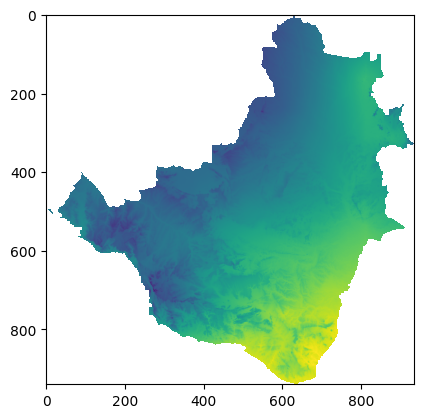

In [5]:
#@title Generate Means GeoTif.

def get_xgb_isoscape_prediction(model: xgb.XGBRegressor):
  '''returns an isoscape with a set of means predicted using the XGBoost
  model.'''
  bounds = raster.get_extent(raster.cellulose_isoscape_geotiff().gdal_dataset)
  features = [raster.relative_humidity_geotiff(),
              raster.temperature_geotiff(),
              raster.vapor_pressure_deficit_geotiff(),
              raster.atmosphere_isoscape_geotiff()]
  image_feature_names = ["rh", "temp", "vpd", "atmosphere_oxygen_ratio"]
  feature_names = ["lat", "long"] + image_feature_names
  predicted_isoscape = np.ma.array(np.zeros([bounds.raster_size_x, bounds.raster_size_y, 1], dtype=float), mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 1], dtype=bool))

  for x_idx, x in enumerate(tqdm(np.arange(bounds.minx, bounds.maxx, bounds.pixel_size_x, dtype=float))):
    rows = []
    row_indexes = []
    for y_idx, y in enumerate(np.arange(bounds.miny, bounds.maxy, -bounds.pixel_size_y, dtype=float)):
      month = 0
      row = {}
      try:
        for feature, feature_name in zip(features, image_feature_names):
          row[feature_name] = raster.get_data_at_coords(feature, x, y, month)
        row["long"] = x
        row["lat"] = y
      except ValueError:
        # masked and out-of-bounds coordinates
        continue
      except IndexError:
        continue
      rows.append(row)
      row_indexes.append((y_idx,month,))
    if len(rows) > 0:
      reordered = pd.DataFrame(rows)[model.get_booster().feature_names]
      predictions = model.predict(reordered)
      predictions_np = predictions
      for prediction, (y_idx, month_idx) in zip(predictions_np, row_indexes):
        predicted_isoscape.mask[x_idx,y_idx,month_idx] = False # unmask since we have data
        predicted_isoscape.data[x_idx,y_idx,month_idx] = prediction

  return predicted_isoscape

if REGENERATE_OXYGEN_XGB_ISOSCAPE:
  xgb_isoscape_prediction = get_xgb_isoscape_prediction(xgb_model)
  raster.save_numpy_to_geotiff(raster.get_extent(
      raster.cellulose_isoscape_geotiff().gdal_dataset),
                               xgb_isoscape_prediction,
                               raster.get_model_path("predicted_isoscape_xgboost.tiff"))
  plt.imshow(xgb_isoscape_prediction)

# TODO: TESTME!

Driver: GTiff/GeoTIFF
Size is 940 x 936 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-73.975139313, 5.266527396)
Pixel Size = (0.0416666665, -0.041666666500000005)


100%|██████████| 936/936 [1:17:11<00:00,  4.95s/it]


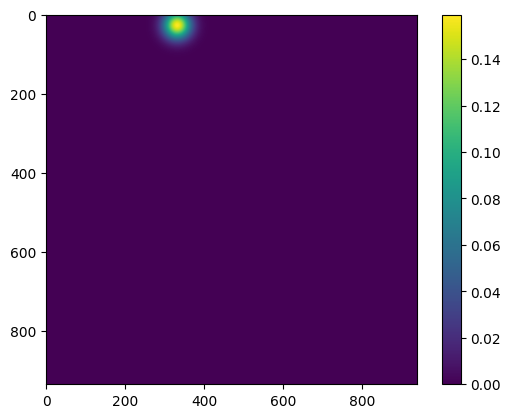

In [6]:
#@title Generate Variance GeoTif.
import gaussian

predicted_cellulose_isoscape_geotiff = raster.load_raster(raster.get_model_path("predicted_isoscape_xgboost.tiff"))
plt.imshow(predicted_cellulose_isoscape_geotiff.yearly_masked_image)

rv = gaussian.get_2d_gaussian(-60.16, 4.11, 1)
gaussian.plot_gaussian(rv, raster.get_extent(predicted_cellulose_isoscape_geotiff.gdal_dataset))

if REGENERATE_OXYGEN_XGB_MEANS_VARIANCES:
  xgb_means, xgb_variances = gaussian.gaussian_kernel(predicted_cellulose_isoscape_geotiff, stdev_in_degrees=0.1)
  bds = raster.get_extent(predicted_cellulose_isoscape_geotiff.gdal_dataset)
  raster.save_numpy_to_geotiff(bds, np.expand_dims(xgb_means, axis=2),
                               raster.get_model_path(f"xgb_means_oxygen_isoscape_{ISOSCAPE_SUFFIX}.tiff"))
  raster.save_numpy_to_geotiff(bds, np.expand_dims(xgb_variances, axis=2),
                                raster.get_model_path(f"xgb_variances_oxygen_isoscape_{ISOSCAPE_SUFFIX}.tiff"))


Driver: GTiff/GeoTIFF
Size is 940 x 936 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-73.975139313, 5.266527396)
Pixel Size = (0.0416666665, -0.041666666500000005)
Driver: GTiff/GeoTIFF
Size is 940 x 936 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-73.975139313, 5.266527396)
Pixel Size = (0.0416666665, -0.041666666500000005)


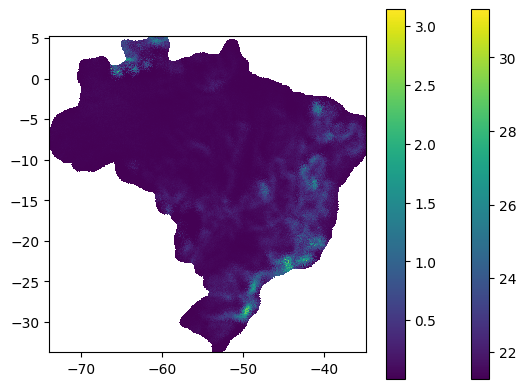

In [7]:
#@title Display Results.
xgb_means_oxygen_geotiff = raster.load_raster(raster.get_model_path(f"xgb_means_oxygen_isoscape_{ISOSCAPE_SUFFIX}.tiff"))
xgb_variances_oxygen_geotiff = raster.load_raster(raster.get_model_path(f"xgb_variances_oxygen_isoscape_{ISOSCAPE_SUFFIX}.tiff"))

# Until we re-generate the map
xgb_variances_oxygen_geotiff.yearly_masked_image *= (5 / 4)
xgb_variances_oxygen_geotiff.masked_image *= (5 / 4)
raster.plot_band(xgb_means_oxygen_geotiff, 0)
raster.plot_band(xgb_variances_oxygen_geotiff, 0)
